In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string
import seaborn as sn
from math import *
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demet\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
#dosyaları oku
ham_files = [name for name in sorted(os.listdir('training\ham'))]
ham_files=filter(lambda x: x[-4:] == '.txt', ham_files)
spam_files = [name for name in sorted(os.listdir('training\spam'))]
spam_files=filter(lambda x: x[-4:] == '.txt', spam_files)
data=[]
target=[]

In [3]:
#spam ve hamları dataya ekle, targetlarını 1 0 olarak düzenle
for each in ham_files:
    directory = "training\ham/"
    f=open(directory+ each, "r")
    data.append(f.read())
    target.append(0)
    ham_len=len(data)
        
for each in spam_files:
    directory = "training\spam/"
    f=open(directory+ each, "r")
    data.append(f.read())
    target.append(1)
    spam_len=len(data)-ham_len

In [4]:
print(ham_len,spam_len)

375 375


In [5]:
#maillerin subjectlerine bak eğer içinde re fw fwd varsa yanıtlanma columnu 1 olsun
def subj(data):
    subject=[]
    re=[]
    content=[]
    for each in data:
        sub=each.split("\n")[0]
        content.append(each.split(sub+"\n")[1])
        x="Subject:"
        subject.append(sub.split(x)[1])
        if " fw " in sub.split(x)[1] or " fwd " in sub.split(x)[1] or " re " in sub.split(x)[1]:
            re.append(1)
        else:
            re.append(0)
    return subject,re,content

In [6]:
#dataframe'e dönüştür
subject,re,content=subj(data)
df=pd.DataFrame(list(zip(subject,re,content,target)),columns=["subject","re","content","target"]) 
df["content"]=[each.replace("\n"," ") for each in df["content"]]

df

,subject,re,content,target
0,re : congratulations,1,thanks . congratulations to you . ray vince j ...,0
1,re : congratulations,1,right back at you . . . . . great job,0
2,re : congratulations,1,"vince , congratulations to you too ! in my min...",0
3,kudos,0,congratulations on your promotion - - well des...,0
4,re : congrats,1,"vince , thanks for the note - and congratulati...",0
...,...,...,...,...
745,candy super $ money maker,0,you are receiving this message as an opt - in ...,1
746,construção e reforma em 12 x,0,"( por favor , não responda esse e - mail ! ) o...",1
747,you can get a quote from 4 major lenders with...,0,you can get a quote at 4 lenders with no perso...,1
748,how to soak her in cum,0,""" i just wanted to write and thank you for spu...",1


In [7]:
df["content"].head()

0    thanks . congratulations to you . ray vince j ...
1                right back at you . . . . . great job
2    vince , congratulations to you too ! in my min...
3    congratulations on your promotion - - well des...
4    vince , thanks for the note - and congratulati...
Name: content, dtype: object

In [8]:
#string.punctuation ve stopwords'e göre temizlik. ($ hariç)
def cleaning(cont):
    cont_clean=[x for x in cont if x not in string.punctuation.replace("$", "") ]
    cont_clean="".join(cont_clean).split()
    cont_clean = [each.lower() for each in cont_clean if each.lower() not in stopwords.words("english")]
    return cont_clean

In [9]:
#content ve subject için temizlik yap
df["clean_content"]=df['content'].apply(cleaning)
df["subject"]=df['subject'].apply(cleaning)


In [10]:
df.head()

,subject,re,content,target,clean_content
0,[congratulations],1,thanks . congratulations to you . ray vince j ...,0,"[thanks, congratulations, ray, vince, j, kamin..."
1,[congratulations],1,right back at you . . . . . great job,0,"[right, back, great, job]"
2,[congratulations],1,"vince , congratulations to you too ! in my min...",0,"[vince, congratulations, mind, always, md, off..."
3,[kudos],0,congratulations on your promotion - - well des...,0,"[congratulations, promotion, well, deserved, l..."
4,[congrats],1,"vince , thanks for the note - and congratulati...",0,"[vince, thanks, note, congratulations, well, m..."


In [11]:
#mailde en çok kullanılan spam ve ham kelimelerini bul,
words_ham=[]
words_spam=[]
x=df[df["target"]==0]
for each in x["clean_content"]:
    for w in each:
        words_ham.append(w) #ham kelimelerine ekle
y=df[df["target"]==1]       
for each in y["clean_content"]:
    for w in each:
        words_spam.append(w) #spam kelimelerine ekle
sp_words1=pd.Series(words_spam).value_counts()[:300] #en çok tekrar eden 300ünü al
sp_words=sp_words1.index.tolist()
hm_words1=pd.Series(words_ham).value_counts()[:300]
hm_words=hm_words1.index.tolist()
sp_w=list(set(sp_words).difference(set(hm_words))) #spamda olup hamda olmayanlar
hm_w=list(set(hm_words).difference(set(sp_words)))#hamda olup spamda olmayanlar
# mail ve subject kelime sayısını bul
df['length']=[len(each) for each in df['clean_content']]
df['sub_length']=[len(each) for each in df['subject']]

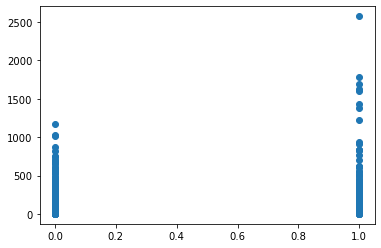

In [12]:
#ham ve spamlara göre uzunluklar
plt.scatter(df.target,df.length);

In [13]:
#subjectte en çok kullanılan kelimeleri bul (spam ve ham için ayrı ayrı)
words_ham1=[]
words_spam1=[]
x=df[df["target"]==0]
for each in x["subject"]:
    for w in each:
        words_ham1.append(w) #ham kelimelerine ekle
y=df[df["target"]==1]       
for each in y["subject"]:
    for w in each:
        words_spam1.append(w) #spam kelimelerine ekle
sp_words12=pd.Series(words_spam1).value_counts()
sp_words2=sp_words12.index.tolist()
hm_words12=pd.Series(words_ham1).value_counts()
hm_words2=hm_words12.index.tolist()
sp_w2=list(set(sp_words2).difference(set(hm_words2))) #spamda olup hamda olmayanlar
hm_w2=list(set(hm_words2).difference(set(sp_words2))) #hamda olup spamda olmayanlar

In [14]:
sp_w2 #spam subj. kelimeleri

['30314',
 '8859',
 'lender',
 '24344',
 'also',
 'loss',
 'complete',
 '8456',
 'gains',
 'propecia',
 'medz',
 '14',
 '21846',
 'service',
 'ch',
 'hour',
 'mortgage',
 'maker',
 'home',
 'favorite',
 'unlimited',
 'password',
 'yrs',
 'registration',
 'travel',
 '499',
 'pharmacists',
 'teach',
 '84',
 'services',
 'revolutionize',
 'hywwzzlzd',
 'lancer',
 'aro',
 'soak',
 'pic',
 '21231',
 'fresh',
 'op',
 'need',
 '35',
 'satisfy',
 'rpvnltb',
 'sex',
 'begins',
 'property',
 'creative',
 '11956',
 'without',
 'breast',
 'blue',
 'naturally',
 'complimentary',
 'x',
 'hloy',
 'cheap',
 'greatt',
 'lift',
 'checking',
 'mlm',
 'tv',
 'era',
 'set',
 'accesos',
 'weekly',
 'funding',
 'wanna',
 'totaly',
 'cialis',
 'manuel',
 'zuyw',
 'ultimate',
 'company',
 'saling',
 'yotgy',
 'viagra',
 'alternative',
 'try',
 'none',
 'lose',
 'ground',
 'jif',
 'years',
 'reduction',
 'easy',
 'jump',
 'horseshoe',
 'forget',
 'longer',
 'protect',
 'logo',
 'rkq',
 'cash',
 'usa',
 '2002',


In [15]:
hm_w2  #ham subj. kelimeleri

['group',
 'vl',
 'visit',
 'outing',
 'modeling',
 'eci',
 'receipts',
 'engineers',
 'congrats',
 'end',
 'referral',
 'approval',
 'posey',
 'rice',
 'corp',
 'copier',
 'halliburton',
 'interview',
 'location',
 'patricia',
 'series',
 'scheduled',
 'bartarya',
 'telecom',
 'asap',
 'payne',
 'follow',
 'derivatives',
 'maria',
 'training',
 'cruel',
 'research',
 'mit',
 'day',
 'forecasts',
 'option',
 'gas',
 'allen',
 'boston',
 'cpm',
 'iv',
 'feb',
 'enterprise',
 'methodology',
 'czesc',
 'rodeo',
 'oliveira',
 'brought',
 'zealot',
 'michael',
 'chelmsford',
 'paula',
 'family',
 'public',
 'bearish',
 'vacation',
 'expo',
 'kellogg',
 'revolution',
 '150',
 'finance',
 'storage',
 'enroncredit',
 'curve',
 'zero',
 'eb',
 'baby',
 'grms',
 'associates',
 '5018',
 'dalton',
 'fyi',
 'mccoy',
 'joining',
 'h',
 'electricxity',
 'project',
 'seyfried',
 'ledis',
 'australian',
 'south',
 'elements',
 'admired',
 'var',
 'yaman',
 'wednesday',
 '16',
 'bryan',
 'fas',
 'resche

In [16]:
score1=[]
scoreh1=[]
sc1=0
sch1=0

for each in df["clean_content"]:
    for w in each:
        if w in sp_w: #mail içinde kelimelere bak eğer kelime spam kelimesiyse
            sc1+=1 #spam skoruna 1 ekle

        if w in hm_w:  #mail içinde kelimelere bak eğer kelime ham kelimesiyse
            sch1+=1 #ham skoruna 1 ekle

    score1.append(sc1) #mailin toplam spam skorunu ekle
    scoreh1.append(sch1) #mailin toplam ham skorunu ekle
    sc1=0
    sch1=0
df["score_s"]=score1 #column oluştur
df["score_h"]=scoreh1

In [17]:
score=[]
scoreh=[]
sc=0
sch=0

for each in df["subject"]:
    for w in each:
        if w in sp_w2: #mail subjecti içinde kelimelere bak eğer kelime spam kelimesiyse
            sc+=1 #spam skoruna 1 ekle

        if w in hm_w2: #mail subjecti içinde kelimelere bak eğer kelime ham kelimesiyse
            sch+=1 #ham skoruna 1 ekle

    score.append(sc) #mailin toplam spam skorunu ekle
    scoreh.append(sch) #mailin toplam ham skorunu ekle
    sc=0
    sch=0
df["sub_score_s"]=score #column oluştur
df["sub_score_h"]=scoreh

In [18]:
df.head()

,subject,re,content,target,clean_content,length,sub_length,score_s,score_h,sub_score_s,sub_score_h
0,[congratulations],1,thanks . congratulations to you . ray vince j ...,0,"[thanks, congratulations, ray, vince, j, kamin...",24,1,0,16,0,0
1,[congratulations],1,right back at you . . . . . great job,0,"[right, back, great, job]",4,1,0,0,0,0
2,[congratulations],1,"vince , congratulations to you too ! in my min...",0,"[vince, congratulations, mind, always, md, off...",35,1,1,18,0,0
3,[kudos],0,congratulations on your promotion - - well des...,0,"[congratulations, promotion, well, deserved, l...",5,1,0,1,0,1
4,[congrats],1,"vince , thanks for the note - and congratulati...",0,"[vince, thanks, note, congratulations, well, m...",63,1,0,27,0,1


In [19]:
df.drop(["subject","content","clean_content"],axis=1,inplace=True) #sayısal olmayanları çıkart

In [20]:
#kaç kelime içinde kaç spam kelimesi var, orana çevir.
df["sub_score_s"]=df["sub_score_s"]/df["sub_length"] 
df["sub_score_h"]=df["sub_score_h"]/df["sub_length"] 
df["score_s"]=df["score_s"]/df["length"] 
df["score_h"]=df["score_h"]/df["length"] 

df=df.fillna(0) #bölerken 0 olanlar nan oldu onları tekrar 0la doldurduk.

In [21]:
#test verisi için veri önişleme kısmı

def fonk(directory):
    files_test = [name for name in sorted(os.listdir(directory))]
    files_test=filter(lambda x: x[-4:] == '.txt', files_test)
    data_test=[]
    for each in files_test:
        directory_test = directory
        f_test=open(directory+ each, "r")
        data_test.append(f_test.read())
    
    subject,re,content=subj(data_test)
    #df yap, uzunlukları ve temizlemeleri yap
    df_test=pd.DataFrame(list(zip(subject,re,content)),columns=["subject","re","content"])
    
    df_test["content"]=[each.replace("\n"," ") for each in df_test["content"]]
    df_test["clean_content"]=df_test['content'].apply(cleaning)
    df_test["subject"]=df_test['subject'].apply(cleaning)
    df_test['length']=[len(each) for each in df_test['clean_content']]
    df_test['sub_length']=[len(each) for each in df_test['subject']]
    #önceden train verileriyle oluşturulan spam kelimeleri ve ham kelimeleri listelerine göre puan columnu oluştur.
    score1=[]
    scoreh1=[]
    sc1=0
    sch1=0

    for each in df_test["clean_content"]:
        for w in each:
            if w in sp_w:
                sc1+=1

            if w in hm_w:
                sch1+=1

        score1.append(sc1)
        scoreh1.append(sch1)
        sc1=0
        sch1=0


    score=[]
    scoreh=[]
    sc=0
    sch=0

    for each in df_test["subject"]:
        for w in each:
            if w in sp_w2:
                sc+=1

            if w in hm_w2:
                sch+=1

        score.append(sc)
        scoreh.append(sch)
        sc=0
        sch=0
    df_test["sub_score_s"]=score
    df_test["sub_score_h"]=scoreh

    df_test["score_s"]=score1
    df_test["score_h"]=scoreh1
    return df_test

In [22]:
#test verilerini oku ve ön işlemesini yap
direct="development\spam/"       
df_test=fonk(direct)
df_test["target"]=1

direct2="development\ham/"       
df_test2=fonk(direct2)
df_test2["target"]=0

# testteki ham ve spam verilerini birleştir
df_t=pd.concat([df_test2, df_test], ignore_index=True)



In [23]:
#test için sayısal olmayanları çıkart oranları bul. 0 a bölünce nan olanları tekrar 0 yap.

df_t.drop(["subject","content","clean_content"],axis=1,inplace=True)

df_t["sub_score_s"]= df_t["sub_score_s"]/df_t["sub_length"] 
df_t["sub_score_h"]=df_t["sub_score_h"]/df_t["sub_length"] 
df_t["score_s"]=df_t["score_s"]/df_t["length"] 
df_t["score_h"]=df_t["score_h"]/df_t["length"] 
df_t=df_t.fillna(0)

In [24]:
df_t

,re,length,sub_length,sub_score_s,sub_score_h,score_s,score_h,target
0,1,1,1,0.0,0.000000,0.000000,1.000000,0
1,1,37,2,0.0,1.000000,0.000000,0.351351,0
2,0,102,6,0.0,0.833333,0.000000,0.176471,0
3,0,85,2,0.0,0.000000,0.035294,0.094118,0
4,0,36,2,0.0,0.500000,0.000000,0.083333,0
...,...,...,...,...,...,...,...,...
176,0,51,2,0.0,0.000000,0.137255,0.019608,1
177,0,111,5,0.8,0.200000,0.144144,0.099099,1
178,0,111,5,0.6,0.000000,0.171171,0.063063,1
179,0,45,5,0.4,0.400000,0.288889,0.000000,1


<AxesSubplot:>

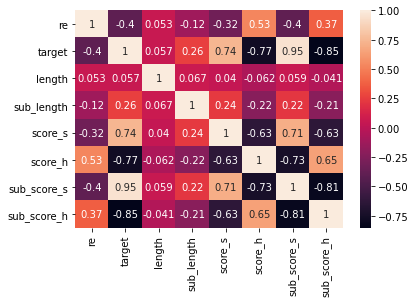

In [25]:
crr=df.corr()
sn.heatmap(crr,annot=True)

In [26]:
df = df.reindex(sorted(df.columns), axis=1)
df_t = df_t.reindex(sorted(df_t.columns), axis=1)
df=round(df, 3)
df_t=round(df_t, 3)
#naive bayes gaussian formülü için mean ve varyans bul
m=df.groupby(by="target").mean()
m=np.array(m)
v=df.groupby(by="target").var()
v=np.array(v)

In [27]:
def probability(m, v, test): # test verilerinin spam olma olasılığı/ham olma olasılığı
    column_count = m.shape[1]
    olasılık = np.ones(2)
    for i in range(2):
        result = 1
        for j in range(column_count):
            try:
                result = result * (1/sqrt(2*3.14*v[i][j])) *exp(-0.5* pow((test[j] - m[i][j]),2)/v[i][j])
            except:
                result = result * (1/sqrt(2*3.14*0.001)) *exp(-0.5* pow((test[j] - m[i][j]),2)/0.001) #if varyans==0
        olasılık[i] = result
    return olasılık

In [28]:
def train_prob(tr_): # tüm y_train verilerinde spamların tamamına oranı ve hamların tamamına oranı.
    y_count=[0,0]
    for each in tr_:
        if each==0:
            y_count[0]+=1
        else:
            y_count[1]+=1
    tr=np.array(tr_)
    pro_list = np.ones(2)
    for each in range(2):
        pro_list[each] = y_count[each]/tr_.shape[0] #tamamına oranları
    return pro_list

In [29]:
y_predd=[] #tahmin listesi
for each in range(len(df_t["target"])): #test verisi kadar 
    tplm = 0
    test_x=np.array(df_t.drop(["target"],axis=1).iloc[each,:]) #sıradaki row için
    olasılık = probability(m, v, test_x)

    pro_list= train_prob(df.target)

    s_or_h = np.ones(2)
    
    for i in range(2):
        tplm = tplm + (olasılık[i] * pro_list[i])
    for i in range(2):
        s_or_h[i] = (olasılık[i] * pro_list[i])/tplm
    if s_or_h[0]>s_or_h[1]:
        tahmin = 0 #hangisinin olasılığı yüksekse 
    else:
        tahmin=1
    y_predd.append(tahmin) 

In [30]:
y_predd

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [31]:
y_test=df_t["target"]
tn, fp, fn, tp =confusion_matrix(y_test,y_predd).ravel()
confusion_matrix(y_test,y_predd).ravel()

array([87,  3,  8, 83], dtype=int64)

In [32]:
accuracy= (tp+tn)/(tp+fp+tn+fn)
accuracy

0.9392265193370166

In [33]:
prec= tp/(tp+fp)
prec

0.9651162790697675

In [34]:
recall= tp/(fn+tp)
recall

0.9120879120879121

In [35]:
f1_measure= (2*prec*recall)/(prec+recall)
f1_measure

0.9378531073446328